In [527]:
from tslearn.metrics import cdist_dtw as ts_dtw
from tslearn.metrics import cdist_soft_dtw as ts_soft_dtw
from sktime.dists_kernels import DtwDist as sk_dtw
from dtaidistance import dtw as dtai_dtw

from dtaidistance.dtw_barycenter import dba_loop as dtai_dba
from tslearn.barycenters import dtw_barycenter_averaging as ts_dba
from tslearn.barycenters import softdtw_barycenter as ts_soft_dba
from tslearn.barycenters import euclidean_barycenter as ts_euc_center

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import time
import matplotlib.pyplot as plt
import Transform

https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.dtw_distance.html  
https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw.html  
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html#dtw-between-multiple-time-series

In [3]:
dataset_name = 'Kenya_90k_Set_1_w90_pW'
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'
window_cols, window_len = Transform.retrive_window_col_names(dataset_name)

In [4]:
sub_sample = 100
start_time = time.time()
df = pl.read_csv(dataset_location).sample(n=sub_sample).to_pandas()
data = df[window_cols].values
print(f'Polars Time: {np.round(time.time() - start_time,2)}[s]')  

Polars Time: 1.53[s]


---
---
# Distance Matrix (DTW)

---
## tslearn 

In [5]:
start_time = time.time()
ts_dist = ts_dtw(data.reshape(-1, window_len, 1))
print(f'tslearn Time: {np.round(time.time() - start_time,2)}[s]')  

tslearn Time: 1.57[s]


In [6]:
ts_dist.shape

(100, 100)

### Window = 5

In [7]:
start_time = time.time()
ts_dist_w5 = ts_dtw(data.reshape(-1, window_len, 1), global_constraint = 'sakoe_chiba', sakoe_chiba_radius = 5)
print(f'tslearn (w=5) Time: {np.round(time.time() - start_time,2)}[s]')  

tslearn (w=5) Time: 0.66[s]


In [8]:
ts_dist_w5.shape

(100, 100)

In [9]:
abs((ts_dist - ts_dist_w5)).max()

63.0151014478842

---
## soft-dtw

In [10]:
start_time = time.time()
ts_soft_dist = ts_soft_dtw(data.reshape(-1, window_len, 1))
print(f'tslearn Time: {np.round(time.time() - start_time,2)}[s]')  

tslearn Time: 3.79[s]


In [11]:
abs((ts_dist - ts_soft_dist)).max()

7204.618503175454

---
## sktime

> ***Note***:  
sktime has special data types.  
To use <code>np.arrays</code>, then use *numpy3D*.  
This expectes <code>np.shape = (instances, variables, time points)</code>  
See: https://github.com/sktime/sktime/blob/main/examples/AA_datatypes_and_datasets.ipynb] Section 1.2.2

In [12]:
start_time = time.time()
sk_dist = sk_dtw().transform(X = data.reshape(-1, 1, window_len))
print(f'sktime Time: {np.round(time.time() - start_time,2)}[s]')  

sktime Time: 0.56[s]


In [13]:
sk_dist.shape

(100, 100)

In [14]:
abs((ts_dist - sk_dist)).max()

7204.618503175454

### Window = 5

In [15]:
start_time = time.time()
sk_dist = sk_dtw(window=float(.5)).transform(X = data.reshape(-1, 1, window_len))
print(f'sktime Time: {np.round(time.time() - start_time,2)}[s]')  

sktime Time: 0.49[s]


---
## DTAIDistance
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html#dtw-between-multiple-time-series

In [16]:
start_time = time.time()
dtai_dist = np.array(dtai_dtw.distance_matrix_fast(data, compact=False))
print(f'dtai Time: {np.round(time.time() - start_time,2)}[s]')  

dtai Time: 0.05[s]


In [17]:
df_large = pl.read_csv(dataset_location).sample(n=1000).to_pandas()
data_large = df_large[window_cols].values
start_time = time.time()
dtai_dist_large = np.array(dtai_dtw.distance_matrix_fast(data_large, compact=False))
print(f'dtai_large Time: {np.round(time.time() - start_time,2)}[s]')  

dtai_large Time: 5.23[s]


In [18]:
dtai_dist.shape

(100, 100)

In [19]:
abs((ts_dist - dtai_dist)).max()

0.0

In [20]:
abs((sk_dist - dtai_dist)).max()

7204.618503175454

### Window = 5

In [21]:
start_time = time.time()
dtai_dist = np.array(dtai_dtw.distance_matrix_fast(data, compact=False, window=5))
print(f'dtai (w=5) Time: {np.round(time.time() - start_time,2)}[s]')  

dtai (w=5) Time: 0.01[s]


---
## Speed Test

Text(0, 0.5, 'seconds')

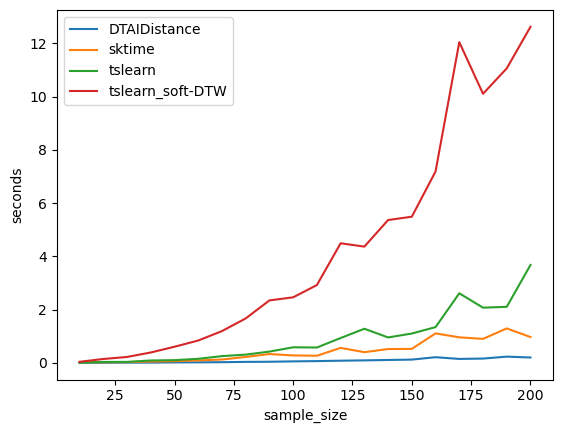

In [22]:
ts_times = []
ts_soft_times = []
sk_times = []
dtai_times = []
for i in range(10, 210, 10):
    print(f'processing: {i}' , end='\r')
    df = pl.read_csv(dataset_location).sample(n=i).to_pandas()
    data = df[window_cols].values

    # ts
    # print('ts')
    start_time = time.time()
    _ = ts_dtw(data.reshape(-1, window_len, 1))
    ts_times.append(time.time() - start_time)
    
    # print('ts_soft')
    # ts_soft
    start_time = time.time()
    _ = ts_soft_dtw(data.reshape(-1, window_len, 1))
    ts_soft_times.append(time.time() - start_time)    
    
    # print('sk')
    # sk
    start_time = time.time()
    _ = sk_dtw().transform(X = data.reshape(-1, 1, window_len))
    sk_times.append(time.time() - start_time)
    
    # print('dtai')
    # dtai
    start_time = time.time()
    dtai_dist = np.array(dtai_dtw.distance_matrix_fast(data, compact=False))
    dtai_times.append(time.time() - start_time)  
    
times = pd.DataFrame()
times['sample_size'] = list(range(10, 210, 10))
times['DTAIDistance'] = dtai_times   
times['sktime'] = sk_times
times['tslearn'] = ts_times
times['tslearn_soft-DTW'] = ts_soft_times

ax = times.plot.line(x='sample_size')
ax.set_ylabel('seconds')

Text(0, 0.5, 'seconds')

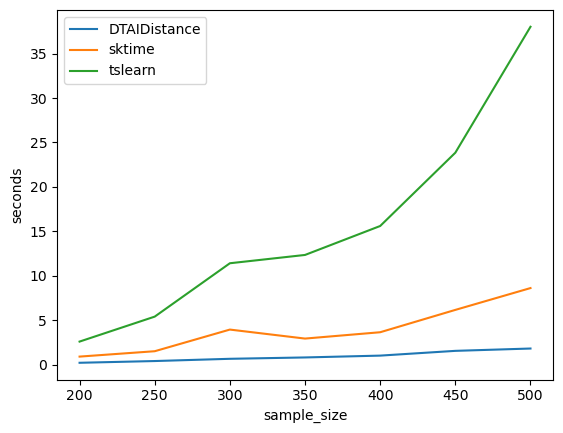

In [23]:
ts_times = []
sk_times = []
dtai_times = []
for i in range(200, 550, 50):
    print(f'processing: {i}' , end='\r')

    df = pl.read_csv(dataset_location).sample(n=i).to_pandas()
    data = df[window_cols].values

    # ts
    # print('ts')
    start_time = time.time()
    _ = ts_dtw(data.reshape(-1, window_len, 1))
    ts_times.append(time.time() - start_time)
    
    # print('sk')
    # sk
    start_time = time.time()
    _ = sk_dtw().transform(X = data.reshape(-1, 1, window_len))
    sk_times.append(time.time() - start_time)
    
    # print('dtai')
    # dtai
    start_time = time.time()
    dtai_dist = np.array(dtai_dtw.distance_matrix_fast(data, compact=False))
    dtai_times.append(time.time() - start_time)   
    
times = pd.DataFrame()
times['sample_size'] = list(range(200, 550, 50))
times['DTAIDistance'] = dtai_times   
times['sktime'] = sk_times
times['tslearn'] = ts_times

ax = times.plot.line(x='sample_size')
ax.set_ylabel('seconds')

## Window = 5

Text(0, 0.5, 'seconds')

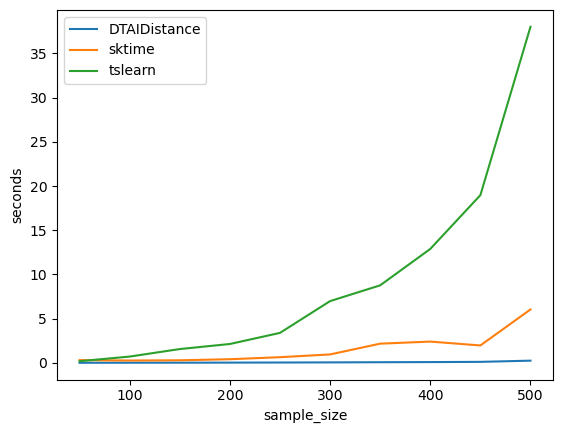

In [24]:
ts_times = []
sk_times = []
dtai_times = []
for i in range(50, 550, 50):
    print(f'processing: {i}' , end='\r')
    df = pl.read_csv(dataset_location).sample(n=i).to_pandas()
    data = df[window_cols].values

    # ts
    # print('ts')
    start_time = time.time()
    _ = ts_dtw(data.reshape(-1, window_len, 1), global_constraint = 'sakoe_chiba', sakoe_chiba_radius = 5)
    ts_times.append(time.time() - start_time)
    
    # print('sk')
    # sk
    start_time = time.time()
    _ = sk_dtw(window=float(.05)).transform(X = data.reshape(-1, 1, window_len))
    sk_times.append(time.time() - start_time)
    
    # print('dtai')
    # dtai
    start_time = time.time()
    _ = np.array(dtai_dtw.distance_matrix_fast(data, compact=False, window=5))
    dtai_times.append(time.time() - start_time)   
    
times = pd.DataFrame()
times['sample_size'] = list(range(50, 550, 50))
times['DTAIDistance'] = dtai_times   
times['sktime'] = sk_times
times['tslearn'] = ts_times

ax = times.plot.line(x='sample_size')
ax.set_ylabel('seconds')

---
# Barycenter (DBA)

In [52]:
def plot_barycenter(X, barycenter, alpha= 0.2):
    # plot all points of the data set
    for series in X:
        plt.plot(series.ravel(), "k-", alpha=alpha)
    # plot the given barycenter of them
    plt.plot(barycenter.ravel(), "r-", linewidth=2)

In [53]:
sub_sample = 10
start_time = time.time()
df = pl.read_csv(dataset_location).sample(n=sub_sample).to_pandas()
data = df[window_cols].values
print(f'Polars Time: {np.round(time.time() - start_time,2)}[s]')  

Polars Time: 0.78[s]


In [549]:
cluster = 6 # 3, 5, 6, 9, 11, 12, 17, 18, 21
sol_subsample = 500
solution = 'LSTM_AE-efficient_sweep_2_v49.csv'
cluster_sol = 'KUMAP_k25'
sol_location = f'../ModelResults/Clustering/Solutions/Kenya_90k_Set_1_w90_pW/{solution}'
df_sol_ids = pl.scan_csv(sol_location).filter(pl.col(f"{cluster_sol}") == cluster).select(["short_ID", "window_ID"]).collect() #.fetch()#.to_pandas()
df_all = pl.read_csv(dataset_location)
df_sol = df_sol_ids.join(df_all, on = ['short_ID', 'window_ID'], how='left').to_pandas()
sol_data = df_sol[window_cols].sample(sol_subsample).values

In [550]:
# df_test = pl.scan_csv(sol_location).select(["short_ID", "window_ID", f'{cluster_sol}']).collect().to_pandas()
# df_test[f'{cluster_sol}'].value_counts()

Cluster Size: 500


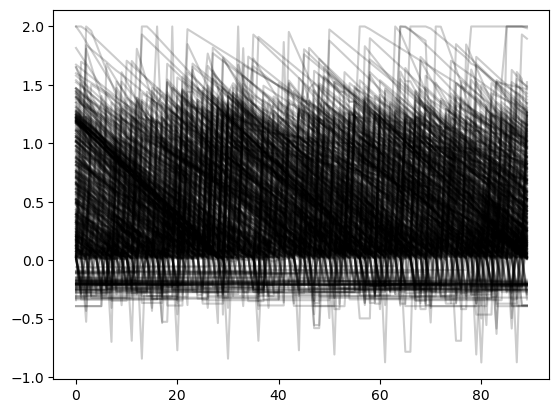

In [551]:
print(f'Cluster Size: {len(sol_data)}')
for series in sol_data:
    plt.plot(series.ravel(), "k-", alpha=0.2)

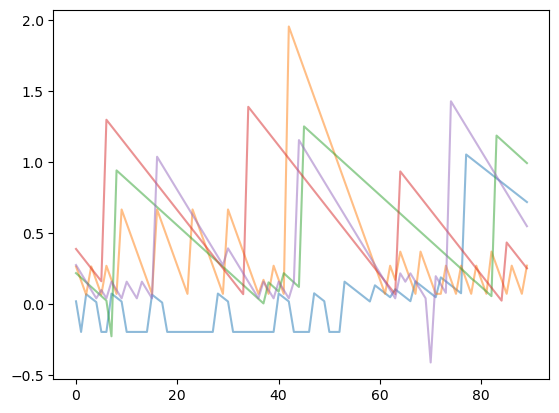

In [564]:
sample = 5
idx = np.random.randint(sol_data.shape[0], size=sample)
# sol_data[idx,:].shape
for series in sol_data[idx,:]:
    plt.plot(series.ravel(), alpha= .5)

---
## Euclidean
https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.euclidean_barycenter.html#tslearn.barycenters.euclidean_barycenter

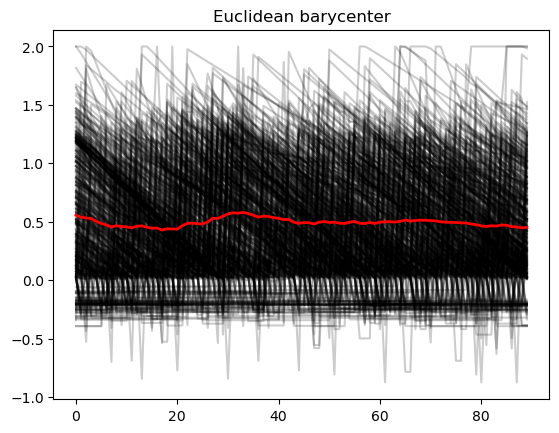

In [553]:
plt.title("Euclidean barycenter")
plot_barycenter(sol_data, sol_data.mean(axis=0))

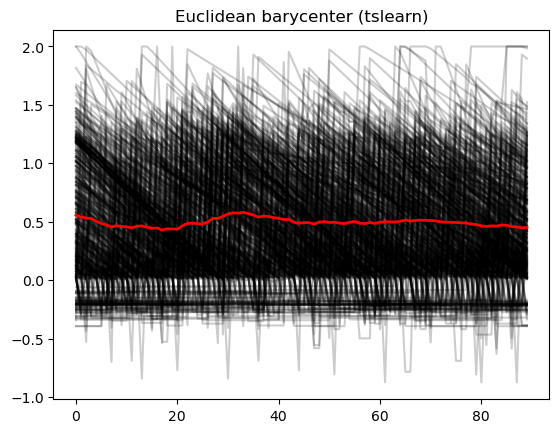

In [554]:
plt.title("Euclidean barycenter (tslearn)")
plot_barycenter(sol_data, ts_euc_center(sol_data).ravel())

---
## DTAIDistance
https://dtaidistance.readthedocs.io/en/latest/modules/dtw_barycenter.html

In [555]:
start_time = time.time()
dtai_barycenter = dtai_dba(sol_data, max_it=10, thr=0.001, use_c=True)
print(f'dtai DBA Time: {np.round(time.time() - start_time,2)}[s] (sample:{sol_subsample}) ')  

dtai DBA Time: 0.28[s] (sample:500) 


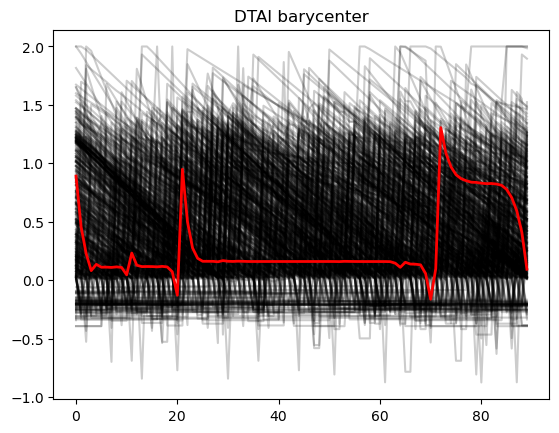

In [556]:
plt.title("DTAI barycenter")
plot_barycenter(sol_data, dtai_barycenter)

---
## tslearn
https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.dtw_barycenter_averaging.html#tslearn.barycenters.dtw_barycenter_averaging

In [557]:
start_time = time.time()
ts_barycenter = ts_dba(sol_data, max_iter=10, tol=0.001)
print(f'tslearn DBA Time: {np.round(time.time() - start_time,2)}[s] (sample:{sol_subsample}) ')  

tslearn DBA Time: 0.83[s] (sample:500) 


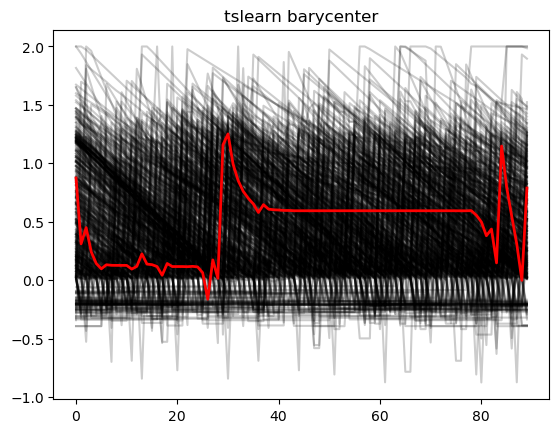

In [558]:
plt.title("tslearn barycenter")
plot_barycenter(sol_data, ts_barycenter.ravel())

---
## soft-tslearn
https://tslearn.readthedocs.io/en/stable/gen_modules/barycenters/tslearn.barycenters.softdtw_barycenter.html#tslearn.barycenters.softdtw_barycenter

In [559]:
start_time = time.time()
ts_soft_barycenter = ts_soft_dba(sol_data, gamma=1.0, tol=0.001, max_iter=10)
print(f'tslearn soft-DBA Time: {np.round(time.time() - start_time,2)}[s] (sample:{sol_subsample}) ')  

tslearn soft-DBA Time: 6.83[s] (sample:500) 


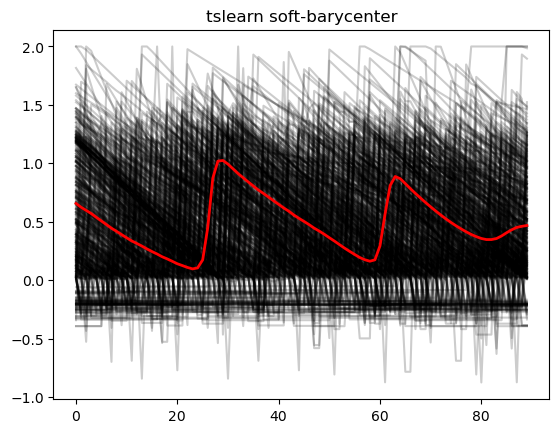

In [560]:
ts_soft_barycenter
plt.title("tslearn soft-barycenter")
plot_barycenter(sol_data, ts_soft_barycenter.ravel())